# Autoencoders

## NeuroWorkshop v2

by [Dmitri Soshnikov](http://fb.com/shwars)


Автоэнкодеры - это попытка пример **self-supervised learning**, когда вместо обучающих примеров мы подаём на вход и выход сети одинаковые данные. Общая идея состоит в том, что мы создаём функцию-кодировщик (*encoder*), которая преобразует данные в некоторое состояние (как правило вектор меньшей размерности), и затем функцию-декодировщик (*decoder*), которая на выходе пытается получить исходное изображение.

Таким образом сеть пытается найти эмбеддинг исходных данных, который сохранял бы их смысл.

![AutoEncoder Diagram](http://blog.keras.io/img/ae/autoencoder_schema.jpg)

Данные примеры во многом заимствованы из [этой прекрасной статьи](https://blog.keras.io/building-autoencoders-in-keras.html).

Важные свойства автоэнкодеров:

* **Data Specific** - они хорошо работают с теми данными, на которых были обучены (не очень подходят для сжатия произвольных данных)
* **Lossy** - воспроизведенное изображение не идентично исходному. Близость изображений определяется функцией потерь (*loss function*) которая использовалась при обучении.
* **Обучение на примерах без разметки**

Основные сценарии использования автоэнкодеров:

* **Уменьшение размерности данных для визуализации**. Обычно удаётся получить более интересные результаты, чем в случае PSA
* **Удаление шумов с изображений**
* **Генеративные модели**

Реализуем простейший автоэнкодер для MNIST:

In [0]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_trainclass), (x_test, y_testclass) = mnist.load_data()

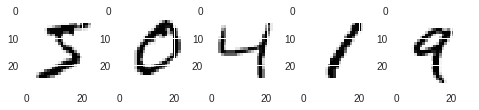

In [4]:
def plotn(n,x):
  fig,ax = plt.subplots(1,n)
  for i,z in enumerate(x[0:n]):
    ax[i].imshow(z.reshape(28,28) if z.size==28*28 else z)
  plt.show()
  
plotn(5,x_train)

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras.losses import binary_crossentropy,mse
from keras import backend as K

input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img,encoded)

input_rep = Input(shape=(4,4,8))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep,decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 11s 185us/step - loss: 0.2180 - val_loss: 0.1655
Epoch 2/25
60000/60000 [==============================] - 7s 122us/step - loss: 0.1575 - val_loss: 0.1500
Epoch 3/25
60000/60000 [==============================] - 7s 121us/step - loss: 0.1425 - val_loss: 0.1378
Epoch 4/25
60000/60000 [==============================] - 7s 121us/step - loss: 0.1339 - val_loss: 0.1280
Epoch 5/25
60000/60000 [==============================] - 7s 121us/step - loss: 0.1288 - val_loss: 0.1222
Epoch 6/25
60000/60000 [==============================] - 7s 121us/step - loss: 0.1253 - val_loss: 0.1302
Epoch 7/25
60000/60000 [==============================] - 7s 121us/step - loss: 0.1222 - val_loss: 0.1232
Epoch 8/25
60000/60000 [==============================] - 7s 121us/step - loss: 0.1201 - val_loss: 0.1232
Epoch 9/25
60000/60000 [==============================] - 7s 119us/step - loss: 0.1183 - val_loss: 0.

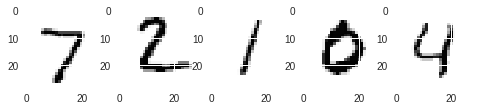

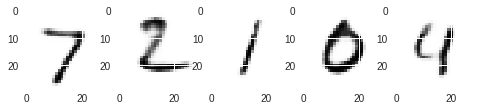

In [8]:
y_test = autoencoder.predict(x_test[0:5])
plotn(5,x_test)
plotn(5,y_test)

In [0]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test[0:5])

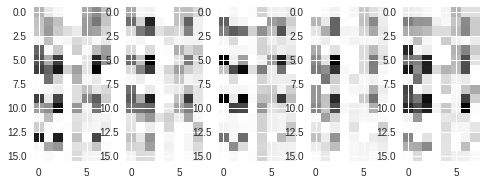

In [10]:
plotn(5,encoded_imgs.reshape(5,-1,8))

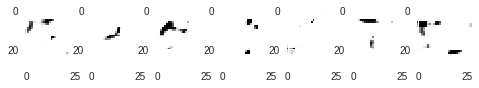

In [14]:
res = decoder.predict(8*np.random.rand(7,4,4,8))
plotn(7,res)

## Denoising

Для удаления шума с картинок также можно эффективно использовать автоэнкодер, который обучается на паре из зашумлённой - не зашумлённой картинки. Для этого добавим к данным MNISТ белый шум: 

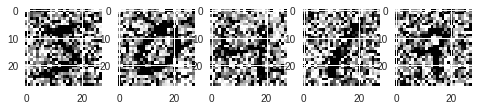

In [15]:
def noisify(data):
  return np.clip(data+np.random.normal(loc=0.5,scale=0.5,size=data.shape),0.,1.)

x_train_noise = noisify(x_train)
x_test_noise = noisify(x_test)

plotn(5,x_train_noise)

In [16]:
autoencoder.fit(x_train_noise, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noise, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 8s 134us/step - loss: 0.1731 - val_loss: 0.1575
Epoch 2/25
60000/60000 [==============================] - 8s 132us/step - loss: 0.1541 - val_loss: 0.1484
Epoch 3/25
60000/60000 [==============================] - 8s 135us/step - loss: 0.1474 - val_loss: 0.1571
Epoch 4/25
60000/60000 [==============================] - 8s 134us/step - loss: 0.1433 - val_loss: 0.1432
Epoch 5/25
60000/60000 [==============================] - 8s 131us/step - loss: 0.1411 - val_loss: 0.1384
Epoch 6/25
60000/60000 [==============================] - 8s 130us/step - loss: 0.1401 - val_loss: 0.1411
Epoch 7/25
60000/60000 [==============================] - 8s 130us/step - loss: 0.1388 - val_loss: 0.1396
Epoch 8/25
60000/60000 [==============================] - 8s 132us/step - loss: 0.1379 - val_loss: 0.1331
Epoch 9/25
60000/60000 [==============================] - 8s 133us/step - loss: 0.1369 - val_loss: 0.1

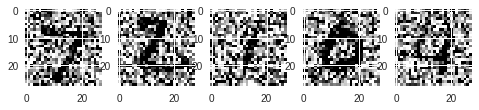

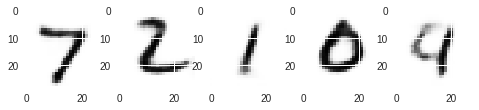

In [17]:
y_test = autoencoder.predict(x_test_noise[0:5])
plotn(5,x_test_noise)
plotn(5,y_test)

## Variational Autoencoders (VAE)

В предыдущих примерах модель сама училась снижать размерность данных каким-то образом. Чтобы сделать промежуточные данные осмысленными (а модель - *генеративной*), попробуем придать смысл промежуточному слою.

VAE - это автоэнкодер, который в качестве промежуточного слоя использует некоторое распределение вероятностей (*латентное распределение*), и учится параметрам распределения (*латентные переменные*) по входным данным.

Используем латентное распределение $N(\mathrm{z\_mean},e^{\mathrm{z\_log\_sigma}})$, где `z_mean`, `z_log_sigma` $\in\mathbb{R}^d$.

VAE работает примерно следующим образом:

 * По входным данным мы строим вектора `z_mean`, `z_log_sigma`
 * Выбираем набор случайных данных `sample` из $N(\mathrm{z\_mean},e^{\mathrm{z\_log\_sigma}})$
 * По ветору `sample` декодер пытается восстановить исходное изображение.

In [0]:
intermediate_dim = 512
latent_dim = 2
batch_size = 128

inputs = Input(shape=(784,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [0]:
def sampling(args):
    z_mean, z_log_sigma = args
    bs = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(bs, latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

In [0]:
encoder = Model(inputs, [z_mean, z_log_sigma, z])

latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs)

outputs = decoder(encoder(inputs)[2])

vae = Model(inputs, outputs)

In [0]:
def vae_loss(x1,x2):
  reconstruction_loss = mse(x1,x2)*784
  tmp = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
  kl_loss = -0.5*K.sum(tmp, axis=-1)
  return K.mean(reconstruction_loss + kl_loss)
  
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [23]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train_flat, x_train_flat,
        shuffle=True,
        epochs=25,
        batch_size=batch_size,
        validation_data=(x_test_flat, x_test_flat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 5s 80us/step - loss: 49.2167 - val_loss: 42.5007
Epoch 2/25
60000/60000 [==============================] - 4s 71us/step - loss: 41.3532 - val_loss: 40.3048
Epoch 3/25
60000/60000 [==============================] - 4s 69us/step - loss: 40.0429 - val_loss: 39.4745
Epoch 4/25
60000/60000 [==============================] - 4s 67us/step - loss: 39.2894 - val_loss: 38.8788
Epoch 5/25
60000/60000 [==============================] - 4s 66us/step - loss: 38.7528 - val_loss: 38.4001
Epoch 6/25
60000/60000 [==============================] - 4s 68us/step - loss: 38.3617 - val_loss: 37.9659
Epoch 7/25
60000/60000 [==============================] - 4s 70us/step - loss: 38.0186 - val_loss: 37.8331
Epoch 8/25
60000/60000 [==============================] - 4s 67us/step - loss: 37.7269 - val_loss: 37.6109
Epoch 9/25
60000/60000 [==============================] - 4s 67us/step - loss: 37.4667 - val_l

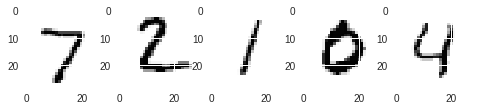

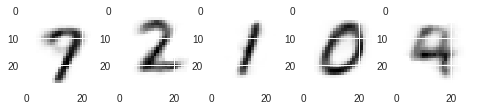

In [24]:
y_test = vae.predict(x_test_flat[0:5])
plotn(5,x_test_flat)
plotn(5,y_test)

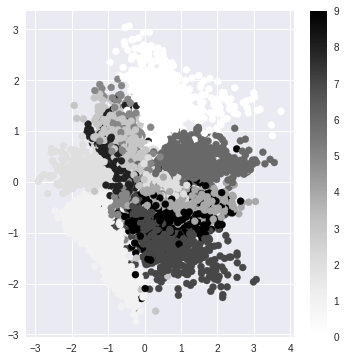

In [27]:
x_test_encoded = encoder.predict(x_test_flat)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_testclass)
plt.colorbar()
plt.show()

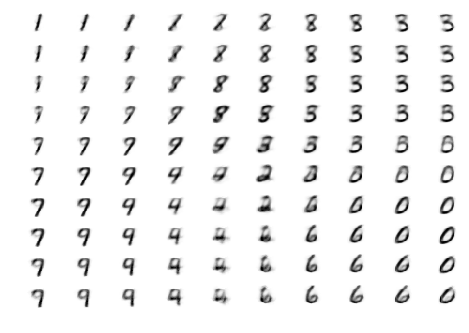

In [34]:
def plotsample(n):
  dx = np.linspace(-1,1,n)
  dy = np.linspace(-1,1,n)
  fig,ax = plt.subplots(n,n)
  for i,xi in enumerate(dx):
    for j,xj in enumerate(dy):
      res = decoder.predict(np.array([xi,xj]).reshape(-1,2))[0]
      ax[i,j].imshow(res.reshape(28,28))
      ax[i,j].axis('off')
  plt.show()
  
plotsample(10)